# **Facial Expression Recognition**

**To build a CNN model to acurately categorize 7 type of human facial expression
which are [sad, happy, disgust, angry, con, fear, surprise]**


**Importing Modules**

In [3]:
#!pip install git+git://github.com/stared/livelossplot.git
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import utils
import os
%matplotlib inline

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Flatten, Dense, Reshape, Multiply, Add,UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import tensorflow as tf
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
# from livelossplot import PlotLossesTensorFlowKeras
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.18.0


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

**Load and Explore the Dataset**

In [6]:
import os
import cv2
import numpy as np

# Path to the CK+ dataset
data_path = 'CK+48'  # Adjust this to your dataset location
print("Dataset Path:", data_path)

# Image parameters
img_rows, img_cols = 48, 48  # Target size for resizing images
num_channel = 1  # Grayscale channel

# List to store image data
img_data_list = []

# Load images from subdirectories
for emotion_dir in os.listdir(data_path):
    emotion_path = os.path.join(data_path, emotion_dir)
    if not os.path.isdir(emotion_path):  # Skip if not a directory
        continue

    print(f'Loaded the images of dataset: {emotion_dir}\n')
    
    for img_file in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, img_file)
        print(f"Processing file: {img_path}")

        if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            print(f"Skipping non-image file: {img_file}")
            continue
        
        input_img = cv2.imread(img_path)
        if input_img is None:
            print(f"Warning: Could not read image {img_path}")
            continue

        # Convert to grayscale and resize
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize = cv2.resize(input_img, (img_rows, img_cols))
        img_data_list.append(input_img_resize)

# Convert the list to a NumPy array
img_data = np.array(img_data_list)
img_data = np.expand_dims(img_data, axis=-1)  # Add channel dimension
img_data = img_data.astype('float32') / 255.0  # Normalize pixel values to [0, 1]

print("Shape of image data:", img_data.shape)


Dataset Path: CK+48
Loaded the images of dataset: happy

Processing file: CK+48/happy/S050_006_00000021.png
Processing file: CK+48/happy/S050_006_00000023.png
Processing file: CK+48/happy/S136_006_00000018.png
Processing file: CK+48/happy/S106_006_00000011.png
Processing file: CK+48/happy/S052_004_00000031.png
Processing file: CK+48/happy/S130_013_00000015.png
Processing file: CK+48/happy/S124_007_00000022.png
Processing file: CK+48/happy/S093_004_00000014.png
Processing file: CK+48/happy/S035_006_00000016.png
Processing file: CK+48/happy/S132_006_00000021.png
Processing file: CK+48/happy/S035_006_00000017.png
Processing file: CK+48/happy/S106_006_00000009.png
Processing file: CK+48/happy/S085_002_00000013.png
Processing file: CK+48/happy/S056_004_00000019.png
Processing file: CK+48/happy/S067_005_00000020.png
Processing file: CK+48/happy/S070_003_00000016.png
Processing file: CK+48/happy/S114_006_00000023.png
Processing file: CK+48/happy/S074_005_00000043.png
Processing file: CK+48/ha

In [7]:
import os
import numpy as np

# Define the dataset path
data_path = 'CK+48'
data_dir_list = os.listdir(data_path)

num_classes = 7

# Define labels dynamically based on folder names
emotion_mapping = {
    'surprise': 0,
    'fear': 1,
    'sadness': 2,
    'disgust': 3,
    'contempt': 4,
    'happy': 5,
    'anger': 6
}

# Check if all expected folders are present
for emotion in emotion_mapping.keys():
    if emotion not in data_dir_list:
        raise ValueError(f"Expected folder '{emotion}' not found in {data_path}")

# Initialize labels
img_data_list = []
labels = []

# Process images and assign labels
for folder_name in data_dir_list:
    folder_path = os.path.join(data_path, folder_name)
    if not os.path.isdir(folder_path):
        print(f"Skipping non-folder item: {folder_name}")
        continue

    # Get the label from the folder name
    if folder_name not in emotion_mapping:
        print(f"Skipping folder not in mapping: {folder_name}")
        continue
    label = emotion_mapping[folder_name]

    # Read images from the folder
    img_list = os.listdir(folder_path)
    for img_name in img_list:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping invalid image: {img_path}")
            continue
        # Resize and preprocess the image
        img_resized = cv2.resize(img, (48, 48))
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_data_list.append(img_gray)
        labels.append(label)

# Convert to numpy arrays
img_data = np.array(img_data_list, dtype='float32') / 255.0
labels = np.array(labels, dtype='int64')

# Reshape img_data to include a channel dimension
img_data = np.expand_dims(img_data, axis=-1)

print("Shape of image data:", img_data.shape)
print("Shape of labels:", labels.shape)


Shape of image data: (981, 48, 48, 1)
Shape of labels: (981,)


In [8]:
import tensorflow as tf
Y = tf.keras.utils.to_categorical(labels, num_classes)
#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)
x_test=X_test

**Augmentation and Preprocessing**

In [9]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
import numpy as np


class StandardizedConv2DWithOverride(layers.Conv2D):
    def convolution_op(self, inputs, kernel):
        mean, var = tf.nn.moments(kernel, axes=[0, 1, 2], keepdims=True)
        return tf.nn.conv2d(
            inputs,
            (kernel - mean) / tf.sqrt(var + 1e-10),
            padding="VALID",
            strides=list(self.strides),
            name=self.__class__.__name__,
        )

**Build the CNN Model**

**Training and Saving the Model**

In [12]:
input_shape=(48,48,3)

#model = Sequential()
#model.add(model)

In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Example shapes of your data (adjust as needed)
# Ensure your data (X_train, y_train, X_test, y_test) is loaded correctly before running this code
print("Original X_train shape:", X_train.shape)  # Should be (num_samples, 48, 48, 1)
print("Original X_test shape:", X_test.shape)    # Should be (num_samples, 48, 48, 1)

# Expand grayscale images to 3 channels
X_train = np.repeat(X_train, 3, axis=-1)  # Duplicate the channel to make it (48, 48, 3)
X_test = np.repeat(X_test, 3, axis=-1)

print("Updated X_train shape:", X_train.shape)  # Should be (num_samples, 48, 48, 3)
print("Updated X_test shape:", X_test.shape)    # Should be (num_samples, 48, 48, 3)

# Example parameters
num_classes = y_train.shape[1]  # Number of emotion categories
input_shape = (48, 48, 3)       # Adjusted input shape
epochs = 15
learning_rate = 1e-3

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
callbacks = [
    ModelCheckpoint('model.keras', monitor="val_accuracy", verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=100)
]

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=7,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Save the trained model
model.save("emotion_detection_model.h5")
print("Model training complete and saved as 'emotion_detection_model.h5'")


Original X_train shape: (833, 48, 48, 1)
Original X_test shape: (148, 48, 48, 1)
Updated X_train shape: (833, 48, 48, 3)
Updated X_test shape: (148, 48, 48, 3)


/home/mankirat/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-27 00:14:35.521043: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63438848 exceeds 10% of free system memory.
2024-11-27 00:14:35.552038: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63438848 exceeds 10% of free system memory.
2024-11-27 00:14:35.580533: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63438848 exceeds 10% of free system memory.


Epoch 1/15


2024-11-27 00:14:36.884380: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63438848 exceeds 10% of free system memory.
2024-11-27 00:14:37.993148: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63438848 exceeds 10% of free system memory.


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.4292 - loss: 3.2293
Epoch 1: val_accuracy improved from -inf to 0.74324, saving model to model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 328ms/step - accuracy: 0.4306 - loss: 3.2153 - val_accuracy: 0.7432 - val_loss: 0.7323 - learning_rate: 0.0010
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9054 - loss: 0.3282
Epoch 2: val_accuracy improved from 0.74324 to 0.97297, saving model to model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 39s 330ms/step - accuracy: 0.9056 - loss: 0.3274 - val_accuracy: 0.9730 - val_loss: 0.0959 - learning_rate: 0.0010
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9670 - loss: 0.1003
Epoch 3: val_accuracy improved from 0.97297 to 0.97973, saving model to model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 316ms/step - accuracy: 0.9669 - loss: 0.1006 - val_accuracy: 0.9797 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 

Model training complete and saved as 'emotion_detection_model.h5'


<Figure size 432x288 with 0 Axes>

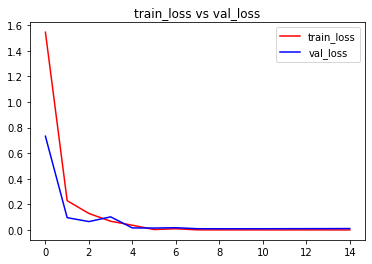

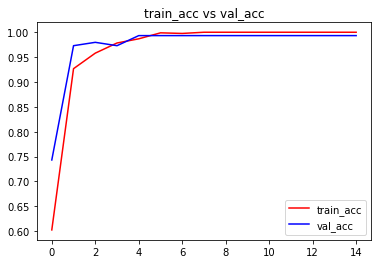

<Figure size 432x288 with 0 Axes>

In [15]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define class labels

class_labels = ['Surprise', 'Fear', 'Sad', 'Disgust', 'Contempt', 'Happy', 'Angry',]
# Function to map index to label
def getLabel(index):
    return class_labels[index]

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

# Predict on a single test image
test_image = X_test[0:1]
print("Test Image Shape:", test_image.shape)

# Model predictions
predictions = model.predict(test_image)
predicted_index = np.argmax(predictions, axis=1)[0]
true_index = np.argmax(y_test[0])  # True label index

print("Predictions:", predictions)
print("Predicted Label:", getLabel(predicted_index))
print("True Label:", getLabel(true_index))

# Predict on the first 9 test images
predictions_9 = model.predict(X_test[0:9])
predicted_indices = np.argmax(predictions_9, axis=1)  # Predicted labels
true_indices = np.argmax(y_test[0:9], axis=1)  # True labels

# Plot the first 9 test images with predictions and true labels
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')  # Adjusted for grayscale images
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.title(f"True: {getLabel(true_indices[i])}\nPredicted: {getLabel(predicted_indices[i])}", fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


NameError: name 'model' is not defined

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


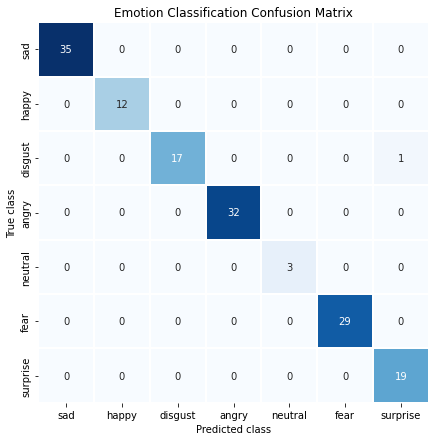

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your model is a functional model
results = model.predict(X_test)

# Convert probabilities to class labels by selecting the index of the highest probability
predicted_classes = np.argmax(results, axis=1)

# Assuming y_test contains one-hot encoded labels, convert it to single labels
y_true = np.argmax(y_test, axis=1)

# Define your emotion labels in the desired order
label = ['sad', 'happy', 'disgust', 'angry', 'neutral', 'fear', 'surprise']

# Define the mapping of class indices to emotion labels
labels = {0: 'sad', 1: 'happy', 2: 'disgust', 3: 'angry', 4: 'neutral', 5: 'fear', 6: 'surprise'}

# Calculate the confusion matrix
cm = confusion_matrix(y_true, predicted_classes)

# Transform to DataFrame for easier plotting
cm_df = pd.DataFrame(cm, index=label, columns=label)

# Create a heatmap with a white-blue color palette ('Blues')
plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', cbar=False, linewidth=2, fmt='d')
plt.title('Emotion Classification Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [19]:
from sklearn.metrics import classification_report

# Assuming you have 'y_true' (true labels) and 'predicted_classes' (predicted labels)
# 'target_names' is a list of class names in the same order as your labels
target_names = ['sad', 'happy', 'disgust', 'angry', 'neutral', 'fear', 'surprise']

# Generate the classification report
report = classification_report(y_true, predicted_classes, target_names=target_names)

# Print the classification report
print(report)


              precision    recall  f1-score   support

         sad       1.00      1.00      1.00        35
       happy       1.00      1.00      1.00        12
     disgust       1.00      0.94      0.97        18
       angry       1.00      1.00      1.00        32
     neutral       1.00      1.00      1.00         3
        fear       1.00      1.00      1.00        29
    surprise       0.95      1.00      0.97        19

    accuracy                           0.99       148
   macro avg       0.99      0.99      0.99       148
weighted avg       0.99      0.99      0.99       148



New Model

ResNet50

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


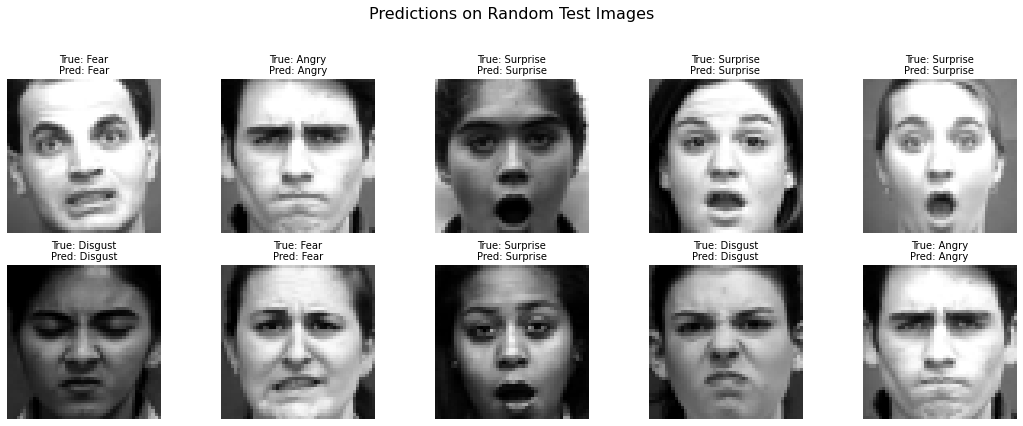

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 10 random indices for the test images
random_indices = np.random.choice(len(X_test), 10, replace=False)

# Create a 2x5 grid layout for displaying 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Predictions on Random Test Images", fontsize=16)

# Loop through each random index and corresponding subplot axis
for i, (test_image_index, ax) in enumerate(zip(random_indices, axes.flatten())):
    # Get the test image and its true label
    test_image = X_test[test_image_index]
    true_label = getLabel(np.argmax(y_test[test_image_index]))

    # Make predictions on the test image using the ResNet-based model
    predictions = model.predict(np.expand_dims(test_image, axis=0))
    predicted_label_index = np.argmax(predictions)
    predicted_label = getLabel(predicted_label_index)

    # Display the test image and its predicted label
    ax.imshow(test_image.squeeze(), cmap='gray')
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
    ax.axis('off')

# Adjust spacing between plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from collections import deque

# Load the pre-trained model
model = load_model('emotion_detection_model.h5')  # Replace with your model's path

# Emotion labels (adjust based on your model's training order)
emotion_labels = ["Surprise", "Fear", "Sad", "Disgust", "Contempt", "Happy", "Angry"]

# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Queue to store rolling predictions for smoother transitions
emotion_history = deque(maxlen=10)  # Keeps the last 10 predictions

def preprocess_frame(face_roi):
    """
    Preprocess the face region of interest (ROI) for prediction.
    """
    face_resized = cv2.resize(face_roi, (48, 48))  # Resize to the input size expected by the model
    face_gray = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    face_expanded = np.expand_dims(face_gray, axis=-1)  # Add channel dimension to make it (48, 48, 1)
    face_repeated = np.repeat(face_expanded, 3, axis=-1)  # Repeat to make it (48, 48, 3)
    face_normalized = face_repeated / 255.0  # Normalize pixel values
    face_input = np.expand_dims(face_normalized, axis=0)  # Add batch dimension to make it (1, 48, 48, 3)
    return face_input

def detect_emotion(frame):
    """
    Detect faces and predict emotions in a frame.
    """
    # Convert the frame to grayscale for face detection
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Extract the region of interest (ROI) for the face
        face_roi = frame[y:y+h, x:x+w]

        # Preprocess the face ROI
        processed_face = preprocess_frame(face_roi)

        # Predict the emotion
        prediction = model.predict(processed_face, verbose=0)
        current_emotion = np.argmax(prediction)

        # Add the prediction to the rolling history
        emotion_history.append(current_emotion)

        # Get the most frequent emotion from the history
        smoothed_emotion = emotion_labels[np.bincount(emotion_history).argmax()]

        # Draw a rectangle around the face and label it with the detected emotion
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, smoothed_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return frame

# Start the webcam feed
def main():
    # Open a connection to the webcam
    cap = cv2.VideoCapture(0)  # Use 0 for the default camera

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    print("Press 'q' to exit.")

    while True:
        # Read a frame from the webcam
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break

        # Detect emotion in the current frame
        processed_frame = detect_emotion(frame)

        # Display the frame with detections
        cv2.imshow('Emotion Detection', processed_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and close OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


2024-11-27 13:56:53.131019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732696013.165911   80170 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732696013.177822   80170 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 13:56:53.219899: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 13:56:57.252866: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

Press 'q' to exit.
